### Introduction

This notebook focuses on analyzing and processing patent data to extract meaningful insights and prepare it for advanced analysis. Patent datasets, rich in structured and unstructured information such as classification codes (CPC, IPC), claims, and descriptions, are crucial for understanding technological trends, innovation patterns, and intellectual property landscapes.

The key objectives of this notebook include:
1. **Data Exploration and Preparation**: Load, clean, and sample a large dataset for efficient processing.
2. **Feature Extraction**: Extract relevant features such as classification codes and claims to enable structured analysis.
3. **Text Processing**: Apply techniques like tokenization, TF-IDF, and embeddings to process unstructured text data.
4. **Visualization and Metrics**: Generate insights by encoding multi-label classifications and evaluating model performance.

By leveraging tools like Python libraries (e.g., pandas, sklearn, Keras) and techniques like MultiLabelBinarizer and TF-IDF, this notebook demonstrates how to handle complex datasets, transforming raw patent data into actionable knowledge for machine learning and other applications.

In [1]:
# Install required packages
!pip install tensorflow pandas numpy keras scikit-learn matplotlib nltk keras-metrics beautifulsoup4


In [2]:
# import packages 
import tensorflow as tf
import pandas as pd  
import numpy as np 
import gzip
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Activation, Dropout, Input, Embedding, Bidirectional, Reshape, Flatten, Conv1D, MaxPooling1D, MaxPool1D, GlobalMaxPool1D, SpatialDropout1D
from keras.layers import concatenate
from tensorflow.keras.preprocessing import text
from keras import utils
from keras import callbacks
from keras import optimizers, models
from sklearn import model_selection, preprocessing, metrics
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import keras_metrics

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import re
import ast
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline

2024-11-18 19:15:19.713198: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antotim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antotim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Preparation

The code prepares and explores a patent dataset by loading a large CSV file and sampling 10,000 rows for manageable analysis. It displays key data fields, including application numbers, dates, classification codes, claims, and descriptions, providing a foundation for further processing and analysis.

In [3]:
df = pd.read_csv('EFREI - LIPSTIP - 50k elements EPO.csv', sep=',', engine='python', on_bad_lines='skip')

In [4]:
df = df.sample(n=10000)

In [5]:
df.head()

,Numéro d'application,Date d'application,Numero de publication,date de publication,CPC,IPC,claim,description
7990,18170396,2018-05-02,3401562,2018-11-14,"['F16C33-583', 'F16C33-3806', 'F16C19-26', 'F1...","['F16C33-58', 'F16C33-38', 'F16C33-66', 'F16C1...","<!-- EPO <DP n=""20""> --><claim id=""c-en-0001"" ...","<!-- EPO <DP n=""1""> --><heading id=""h0001""><b>..."
27806,20169267,2020-04-14,3896613,2021-10-20,"['G06N20-00', 'G06V10-774', 'G06N3-04', 'G06N3...","['G06N3-00', 'G06V10-774']","<!-- EPO <DP n=""20""> --><claim id=""c-en-0001"" ...","<!-- EPO <DP n=""1""> --><p id=""p0001"" num=""0001..."
22123,19168754,2019-04-11,3557180,2019-10-23,"['F41J5-06', 'G01L5-14', 'G01L9-0005', 'G01L1-...","['G01L9-00', 'F41J5-06', 'G01L5-14', 'G01L1-14']","<!-- EPO <DP n=""16""> --><claim id=""c-en-0001"" ...","<!-- EPO <DP n=""1""> --><heading id=""h0001"">BAC..."
40117,17208285,2017-12-19,3339810,2018-06-27,"['A61B5-01', 'G01D1-14', 'G01D1-18', 'A61B5-14...","['A61B5-00', 'G01D1-14', 'G01D1-18', 'H04L29-08']","<!-- EPO <DP n=""37""> --><claim id=""c-en-0001"" ...","<!-- EPO <DP n=""1""> --><heading id=""h0001""><u>..."
18432,18831506,2018-04-16,3653989,2020-05-20,"['G01B11-24', 'A61C9-0053', 'A61C9-006', 'A61C...","['G01B11-00', 'G01B11-24', 'G01S17-89', 'G01C3...","<!-- EPO <DP n=""60""> --><claim id=""c-en-0001"" ...","<!-- EPO <DP n=""1""> --><heading id=""h0001"">TEC..."


In [6]:
df.columns

Index(['Numéro d'application', 'Date d'application', 'Numero de publication',
       'date de publication', 'CPC', 'IPC', 'claim', 'description'],
      dtype='object')

In [7]:
# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()  # Initialize PorterStemmer for stemming

In [8]:
# Function for text preprocessing
def preprocess_text(text):

    # Extract text from XML tags
    soup = BeautifulSoup(text, "lxml")
    clean_text = soup.get_text(separator=' ')

    # Convert text to lowercase
    clean_text = clean_text.lower()

    # Remove punctuation and special characters
    clean_text = re.sub(r'[^a-z0-9\s]', '', clean_text)

    # Specifically remove the word "claim"
    clean_text = clean_text.replace('claim', '')

    # Remove stop words
    clean_text = ' '.join([word for word in clean_text.split() if word not in stop_words])

    return clean_text


In [9]:
# Apply preprocessing

import time

start_time = time.time()

df['claim'] = df['claim'].apply(preprocess_text)
df['description'] = df['description'].apply(preprocess_text)

elapsed_time = time.time() - start_time
print(f"Execution Time: {elapsed_time:.2f} seconds")

Execution Time: 148.80 seconds


In [10]:
# Extract the required columns as DataFrames

claim = df[['Numero de publication', 'claim']]
desc = df[['Numero de publication', 'description']]
cpc = df[['Numero de publication', 'CPC']]

In [11]:
# Concatenate the DataFrames on the 'doc_num' index

X = pd.concat([claim.set_index('Numero de publication'), 
               desc.set_index('Numero de publication')], axis=1).sort_index()

In [12]:
X.shape

(10000, 2)

In [13]:
X.head()

,claim,description
Numero de publication,,
3189756,apparatus comprising housing first second side...,technical field specification relates generall...
3189866,pump comprising compression compartment config...,field invention present invention relates gene...
3189922,device 300 aperture 307 receiving tube 340 com...,field disclosure relates generally gas turbine...
3190141,polymer repeating unit structure represented f...,technical field disclosure relates polymer par...
3192446,bronchial piercing catheter assembly used navi...,background technical field present disclosure ...


In [14]:
# Function to extract unique elements from a string

def extract_unique_elements(string_list):
    try:
        # Convert the string representing a list into a Python list
        elements_list = ast.literal_eval(string_list)
        # Use a set to remove duplicates and return a sorted list
        unique_elements = sorted(set(elements_list))
        # Extract the first character of each element
        first_chars = sorted(set(element[0] for element in unique_elements))
        # Return the list of first characters
        return list(first_chars)
    except ValueError:
        # In case of an error, return an empty string or handle the error as needed
        return ''



In [15]:
# Apply the extraction function to the column and create a new column in the DataFrame
df['nbre_cpc'] = df['CPC'].apply(extract_unique_elements)

# Display the first few rows of the new column
print(df['nbre_cpc'].head())


7990           [F]
27806          [G]
22123       [F, G]
40117    [A, G, H]
18432       [A, G]
Name: nbre_cpc, dtype: object


In [16]:
# Function to count the number of elements in a string representing a list

def count_elements(string_list):
    try:
        # Convert the string representing a list into a Python list
        elements_list = ast.literal_eval(string_list)
        # Return the number of elements in the list
        return len(elements_list)
    except ValueError:
        # In case of an error, return 0 or handle the error as needed
        return 0


In [17]:
# Apply the counting function to the column and find the maximum
max_elements = df['CPC'].apply(count_elements).max()

# Display the maximum number of elements
print("Maximum number of elements in the CPC column:", max_elements)

Maximum number of elements in the CPC column: 66


In [18]:
# Create an empty DataFrame with the correct columns
Y = pd.DataFrame(index=df['Numero de publication'])

# Create columns for each unique element in nbre_cpc
max_elements = df['nbre_cpc'].apply(len).max()
for i in range(1, max_elements + 1):
    Y[f'CPC_{i}'] = ''

# Add elements into the corresponding columns
for idx, row in df.iterrows():
    for i, cpc_code in enumerate(row['nbre_cpc'], start=1):
        Y.at[row['Numero de publication'], f'CPC_{i}'] = cpc_code

# Display the resulting DataFrame Y
print(Y.head())



                      CPC_1 CPC_2 CPC_3 CPC_4 CPC_5
Numero de publication                              
3401562                   F                        
3896613                   G                        
3557180                   F     G                  
3339810                   A     G     H            
3653989                   A     G                  


In [19]:
Y.shape

(10000, 5)

In [20]:
# Data cleaning 
assert Y['CPC_1'].isnull().sum() == 0 # there is no document with 

print("{} documents with null claim".format(X['claim'].isnull().sum()))
print("{} documents with null description".format(X['description'].isnull().sum()))

# Removing documents with null sections (title and abstract)
X_clean = X.dropna(how='any')
null_idx = X[~X.index.isin(X_clean.index)].index # storing the removed indices (i.e. document numbers)
assert X.shape[0] - null_idx.shape[0] == X_clean.shape[0] # making sure the row counts match

# Removing the documents with null sections from the CPC as well 
Y_clean = Y.loc[X_clean.index]

# Some checks
assert X_clean.shape[0] == Y_clean.shape[0]
assert ((Y_clean.index == X_clean.index)*1).sum() == X_clean.shape[0]

# Lower-casing everything
X_clean = X_clean.apply(lambda x: x.str.lower())
Y_clean = Y_clean.apply(lambda x: x.str.lower())

0 documents with null claim
0 documents with null description


In [21]:
print(X_clean.shape)
print(Y_clean.shape)

(10000, 2)
(10000, 5)


In [22]:
X_clean.head()

,claim,description
Numero de publication,,
3189756,apparatus comprising housing first second side...,technical field specification relates generall...
3189866,pump comprising compression compartment config...,field invention present invention relates gene...
3189922,device 300 aperture 307 receiving tube 340 com...,field disclosure relates generally gas turbine...
3190141,polymer repeating unit structure represented f...,technical field disclosure relates polymer par...
3192446,bronchial piercing catheter assembly used navi...,background technical field present disclosure ...


In [23]:
Y_clean.head()

,CPC_1,CPC_2,CPC_3,CPC_4,CPC_5
Numero de publication,,,,,
3189756,a,f,,,
3189866,a,,,,
3189922,b,,,,
3190141,c,,,,
3192446,a,,,,


In [24]:
# Creating dataset 
data = pd.DataFrame()
data = X_clean

# Concat the text of all patent sections and join the labels
# data['full_text'] = + X_clean['claim'] + " " + X_clean['desc']

# Using only the first CPC  
data['CPC_1'] = Y_clean['CPC_1'] 

# Using all labels, merging them in a list and removing None values
data['CPC'] = Y_clean.values.tolist()
data['CPC'] = data['CPC'].apply(lambda x: list(filter(None, x)))

In [25]:
data.head()

,claim,description,CPC_1,CPC
Numero de publication,,,,
3189756,apparatus comprising housing first second side...,technical field specification relates generall...,a,"[a, f]"
3189866,pump comprising compression compartment config...,field invention present invention relates gene...,a,[a]
3189922,device 300 aperture 307 receiving tube 340 com...,field disclosure relates generally gas turbine...,b,[b]
3190141,polymer repeating unit structure represented f...,technical field disclosure relates polymer par...,c,[c]
3192446,bronchial piercing catheter assembly used navi...,background technical field present disclosure ...,a,[a]


#  Encoding Labels with MultiLabelBinarizer

The MultiLabelBinarizer is used to transform a list of labels associated with each data instance into a binary matrix format. Each unique label is represented as a column, and the rows correspond to data instances. If a data instance contains a specific label, the corresponding column is marked with 1; otherwise, it is 0.

This encoding is especially useful for:

Multi-label classification tasks.
Representing label data in a format suitable for machine learning algorithms.

In [26]:
data['CPC'].head()

Numero de publication
3189756    [a, f]
3189866       [a]
3189922       [b]
3190141       [c]
3192446       [a]
Name: CPC, dtype: object

In [27]:
# Converting labels into a binarized matrix with the labels as columns  and each patent document represented in one row
mlb = preprocessing.MultiLabelBinarizer()
cpc = mlb.fit_transform(data['CPC'])

# Checking that the conversion worked as desired by verifying the counts of labels for each document prior and post 
assert data['CPC'].apply(lambda x: len(x)).values.sum() == np.array(pd.DataFrame(cpc).apply(lambda x: x.sum(),axis=1)).sum()

In [28]:
cpc_df = pd.DataFrame(cpc, columns=mlb.classes_)  #.apply(lambda x: x.sum(),axis=1)
cpc_df.head()

,a,b,c,d,e,f,g,h,y
0,1,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0


In [29]:
print("We have {} classes".format(len(mlb.classes_)))

We have 9 classes


In [30]:
# Checking how many times does each label (i.e. class) appear in the data 
# we observe that the classes are a little unbalanced 

pl = cpc_df.apply(lambda x: x.sum(),axis=0).sort_values(ascending=False)  #.plot.bar()
pl.head()

h    3214
g    3021
b    2452
a    1582
y    1374
dtype: int64

# Advanced text processing and TF_IDF

## 1. Advanced Processing

In [31]:
# Removing punctuation
import re, string, timeit

regex = re.compile('[%s]' % re.escape(string.punctuation), re.MULTILINE)

data['claim'] = data['claim'].apply(lambda x : regex.sub("", x))
data['description'] = data['description'].apply(lambda x : regex.sub("", x))

In [32]:
# Removing whitespace
r = re.compile(r"^\s+", re.MULTILINE)

data['claim'] = data['claim'].apply(lambda x : r.sub("", x))
data['description'] = data['description'].apply(lambda x : r.sub("", x))

In [33]:
# Converting to lower - casing 
data['claim'] = data['claim'].apply(lambda x : x.lower())
data['description'] = data['description'].apply(lambda x : x.lower())

In [34]:
# Removing URLs
re_url = re.compile(r'^http\S+', re.MULTILINE|re.UNICODE)

data['claim'] = data['claim'].apply(lambda x : re_url.sub("", x))
data['description'] = data['description'].apply(lambda x : re_url.sub("", x))

In [35]:
# Removing text that has claim and a number
r1 = re.compile(r'(?:claim\S\d+|claim\S \d+|claim \d+|claims?)', re.MULTILINE|re.UNICODE)

data['claim'] = data['claim'].apply(lambda x : r1.sub("", x))
data['description'] = data['description'].apply(lambda x : r1.sub("", x))

In [36]:
# Introducing space on either side of new line
r2 = re.compile(r'.\n', re.MULTILINE|re.UNICODE)

data['claim'] = data['claim'].apply(lambda x : r2.sub(" \n ", x))
data['description'] = data['description'].apply(lambda x : r2.sub(" \n ", x))

In [37]:
# Removing temperature data such as 105°
r2 = re.compile(r"\d+°?", re.MULTILINE)

data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['description'] = data['description'].apply(lambda x : r2.sub("", x))

In [38]:
# Removing special characters \xad
r2 = re.compile(r"\xad", re.MULTILINE)

data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['description'] = data['description'].apply(lambda x : r2.sub("", x))

In [39]:
# Removing special characters - '', and ¬,
data['claim'] = data['claim'].str.replace('\'','')
data['description'] = data['description'].str.replace('\'','')

data['claim'] = data['claim'].str.replace('¬','')
data['description'] = data['description'].str.replace('¬','')

In [40]:
# Removing special characters "' and ¬"
r2 = re.compile(r"[']", re.MULTILINE)

data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['description'] = data['description'].apply(lambda x : r2.sub("", x))

r2 = re.compile(r"[¬]", re.MULTILINE)

data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['description'] = data['description'].apply(lambda x : r2.sub("", x))

In [41]:
# Removing dots from the data
r2 = re.compile(r"[.]", re.MULTILINE)

data['claim'] = data['claim'].apply(lambda x : r2.sub("", x))
data['description'] = data['description'].apply(lambda x : r2.sub("", x))

In [42]:
# Merging all the two sections

data['full_text1'] = X_clean['claim'] +" \n " + X_clean['description']


data['full_text1'].head()

Numero de publication
3189756    apparatus comprising housing first second side...
3189866    pump comprising compression compartment config...
3189922    device  aperture  receiving tube  comprising i...
3190141    polymer repeating unit structure represented f...
3192446    bronchial piercing catheter assembly used navi...
Name: full_text1, dtype: object

# Use Keras tokenizer to create sequences / tokens of the text

The Keras Tokenizer is used to convert text data into sequences of integers (tokens), which are easier for machine learning models to process. It works by:

- Tokenizing: Splitting the text into words (tokens) and assigning each unique word a numeric index.

- Encoding: Converting the text into sequences of integers based on the assigned indices.

- Padding/Truncating: Adjusting the length of sequences to ensure uniformity.

In [43]:
token = text.Tokenizer(filters='.°™\'¯⊘■®') # num_words=sequence_length lower=True
token.fit_on_texts(data['full_text1'])
word_index = token.word_index
print('Number of words in our vocabulary: {}'.format(len(word_index.keys())))

Number of words in our vocabulary: 208026


In [44]:
# Converting the full text to sequences and then back to text.
# This helps in getting the cleaned text after applying filters that used in the keras tokenizer

data_full_text_seq = token.texts_to_sequences(data['full_text1'])
data_full_text_txt = token.sequences_to_texts(data_full_text_seq)

# Create Word embeddings using CBOW (Word2vec) 

The Continuous Bag of Words (CBOW) model, part of Word2Vec, creates word embeddings by predicting a target word based on its surrounding context words. The process involves:

- Input: A window of context words (e.g., words surrounding the target word).

- Output: A dense vector representation (embedding) for each word, capturing semantic meanings and relationships.

- Training: The model adjusts embeddings so that similar words (e.g., synonyms or related concepts) have closer vector representations.

## Create input text for the word embedding algorithm

In [45]:
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import re
from tqdm import tqdm
vocab = Counter()
tokenizer_word = WordPunctTokenizer()


def text_to_wordlist(text):
    
   # Tokenize
    text = tokenizer_word.tokenize(text)
    
   # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text)
        comments.append(txt)
    return comments
CBOW_input_full_text = process_comments(data_full_text_txt)

100%|████████████████████████████████████| 10000/10000 [00:39<00:00, 252.37it/s]


# Gensim Word2Vec - CBOW Model

In [46]:
%%time

import time
import datetime
from gensim.models import Word2Vec

model = Word2Vec(sentences=CBOW_input_full_text,
                 window=5,
                 vector_size=100,
                 min_count=1,  # Adjust min_count based on your data
                 workers=16,   # Adjust workers based on your system
                 sg=0)         # sg=0 for CBOW, sg=1 for skip-gram

# Accessing word vectors
word_vectors = model.wv

# Example to get the number of word vectors
num_word_vectors = len(model.wv.key_to_index)
print("Number of word vectors: {}".format(num_word_vectors))

time.sleep(1)

Number of word vectors: 208025
CPU times: user 11min, sys: 14.1 s, total: 11min 14s
Wall time: 3min 24s


## Create embedding matrix 

In [47]:
# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in vocab:    
        embedding_vector = word_vectors[word]
    else:
        embedding_vector = None
    
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [48]:
embedding_matrix.shape

(208027, 100)

# TF IDF Methodology to extract important words 

The TF-IDF (Term Frequency-Inverse Document Frequency) methodology identifies important words in a document by measuring their relevance in relation to a collection of documents. It works in two steps:

- Term Frequency (TF): Measures how often a word appears in a document.

- Inverse Document Frequency (IDF): Reduces the weight of common words by measuring how often a word appears across all documents.

TF-IDF Score: Combines TF and IDF to highlight words that are frequent in a document but rare in the corpus.

In [49]:
# Initialize a TFIDF Vecxtorizer and pass the preprocessed full text

from sklearn.feature_extraction.text import TfidfVectorizer



tfidf = TfidfVectorizer(lowercase=True, analyzer='word', smooth_idf=False, sublinear_tf=False, norm=None,
                        stop_words='english', ngram_range=(1,1)) 

text_transformed = tfidf.fit_transform(data['full_text1'])

In [50]:
# Transform the data for claim and description using TFIDF model 
# store the TFIDF values for the words for each of the sections

claim_tfidf =  tfidf.transform(data['claim'])
desc_tfidf =  tfidf.transform(data['description'])

In [51]:
# Initialize dataframes to store top words based on TF IDF for each of the sections.

col_names =  ['i','top_words']
max_length = 150
claim_top_words  = pd.DataFrame(columns = col_names)
desc_top_words  = pd.DataFrame(columns = col_names)

## Get top words for Claim using TFIDF
 

In [52]:
feature_names = np.array(tfidf.get_feature_names_out())

for i in tqdm(range(text_transformed.shape[0])):
    f_index = claim_tfidf[i,:].nonzero()[1]
    tfid_score = zip(f_index,[claim_tfidf[i,x] for x in f_index])
   
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
        
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    claim_top_words.loc[len(claim_top_words)] = [i,txt]
    

100%|████████████████████████████████████| 10000/10000 [00:40<00:00, 245.40it/s]


## Get top words for description using TFIDF 

In [53]:
for i in tqdm(range(text_transformed.shape[0])):
    f_index = desc_tfidf[i,:].nonzero()[1]
    tfid_score = zip(f_index,[desc_tfidf[i,x] for x in f_index])
   
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
        
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    desc_top_words.loc[len(desc_top_words)] = [i,txt]

100%|█████████████████████████████████████| 10000/10000 [03:01<00:00, 55.18it/s]


In [54]:
claim_top_words.head()

,i,top_words
0,0,arm drawer wheels wheel position second rollab...
1,1,responsively electrode fraction second fluid p...
2,2,braze necked diameter filler aperture portion ...
3,3,ar alkyl polymer independently ed unsubstitute...
4,4,catheter bronchial piercing tip member assembl...


In [55]:
desc_top_words.head()

,i,top_words
0,0,drawer rollable arm wheels housing position mi...
1,1,irrigation compartment fluid paddle sack elect...
2,2,braze filler tube necked turbine aperture tap ...
3,3,ar polymer substituted polyarylene diradical a...
4,4,catheter ewc piercing bronchial biopsy tip bro...


# Create new datatable to store the top 150 words from each of the 2 sections

In [56]:
desc_top_words.columns = ['desc_no','description']
claim_top_words.columns = ['claim_no','claim']


Data_Final = pd.concat([claim_top_words['claim'], 
           desc_top_words['description']], axis=1).sort_index() 

Data_Final.head()

,claim,description
0,arm drawer wheels wheel position second rollab...,drawer rollable arm wheels housing position mi...
1,responsively electrode fraction second fluid p...,irrigation compartment fluid paddle sack elect...
2,braze necked diameter filler aperture portion ...,braze filler tube necked turbine aperture tap ...
3,ar alkyl polymer independently ed unsubstitute...,ar polymer substituted polyarylene diradical a...
4,catheter bronchial piercing tip member assembl...,catheter ewc piercing bronchial biopsy tip bro...


# Test Train split

In [57]:
# Train test split 

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(Data_Final, cpc, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
     

(8000, 2)
(2000, 2)
(8000, 9)
(2000, 9)


# Padding train and test data and converting them to sequences

In [58]:
# Transforming text documents to sequence of tokens and padding them to ensure equal length vectors
# Choosing the median document length as max length for padding

from tensorflow.keras.preprocessing import sequence

sequence_length = 150

# Creating Input matrix for the two sections for train and test

X_train_claim_seq = sequence.pad_sequences(token.texts_to_sequences(X_train['claim']), maxlen=sequence_length)

X_train_desc_seq = sequence.pad_sequences(token.texts_to_sequences(X_train['description']), maxlen=sequence_length)




X_test_claim_seq = sequence.pad_sequences(token.texts_to_sequences(X_test['claim']), maxlen=sequence_length)

X_test_desc_seq = sequence.pad_sequences(token.texts_to_sequences(X_test['description']), maxlen=sequence_length)



print(X_train_claim_seq.shape)
print(X_test_claim_seq.shape)

(8000, 150)
(2000, 150)


# Hyper parameters for CNN - BILSTM Model

In [59]:
vocabulary_size = embedding_matrix.shape[0]
sequence_length = sequence_length
embedding_dim = embedding_matrix.shape[1]
num_filters = 128
kernel_size = 3
pool_size = 4
units = Y_train.shape[1]  # we need the output nodes to equal the number of classes (96)
lstm_units = 128

learning_rate = 0.001

# Define Training Parameters 

batch_size = 100
epochs = 20

# CNN - BILSTM Model

In [60]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, concatenate, Bidirectional, LSTM, Dense
from tensorflow.keras import models, optimizers

def CNN_BiLSTM_model(sequence_length, vocabulary_size, embedding_dim, embedding_matrix, num_filters, kernel_size, lstm_units, units, learning_rate):
    
    # Claim Channel
    input_layer2 = Input(shape=(sequence_length,), dtype='int32')
    embedding_layer2 = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix], trainable=False)(input_layer2)
    conv_layer2 = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer2)
    dropout_layer2 = Dropout(0.5)(conv_layer2)
    
    # Desc Channel
    input_layer4 = Input(shape=(sequence_length,), dtype='int32')
    embedding_layer4 = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix], trainable=False)(input_layer4)
    conv_layer4 = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer4)
    dropout_layer4 = Dropout(0.5)(conv_layer4)
    
    # Concatenate or Merge
    merged_concat = concatenate([dropout_layer2, dropout_layer4], axis=1)
    
    # Bi-LSTM layer
    bilstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(merged_concat)
    
    # Global Max Pooling
    pool_layer = GlobalMaxPool1D()(bilstm_layer)

    # Output layer
    output_layer = Dense(units=units, activation="sigmoid")(pool_layer)

    # Model compilation with optimizer and learning rate
    optimizer = optimizers.Adam(learning_rate=learning_rate)  # Create optimizer instance with specified LR
    model = models.Model(inputs=[input_layer2, input_layer4], outputs=output_layer)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model



In [61]:
model = CNN_BiLSTM_model(sequence_length, vocabulary_size, embedding_dim, embedding_matrix, num_filters, kernel_size, lstm_units, units, learning_rate) 

In [62]:
%%time 

import time 

# Training CNN-BiLSTM with our own embeddings 

history = model.fit([X_train_claim_seq,X_train_desc_seq], Y_train,  # class_weight=class_weight_dict,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_split=0.1)
time.sleep(1)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.3324 - loss: 0.3782 - val_accuracy: 0.5600 - val_loss: 0.2791
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5420 - loss: 0.2799 - val_accuracy: 0.5800 - val_loss: 0.2579
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6062 - loss: 0.2514 - val_accuracy: 0.6662 - val_loss: 0.2440
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6317 - loss: 0.2378 - val_accuracy: 0.6450 - val_loss: 0.2292
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6511 - loss: 0.2263 - val_accuracy: 0.6938 - val_loss: 0.2209
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6668 - loss: 0.2122 - val_accuracy: 0.6787 - val_loss: 0.2174
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6698 - loss: 0.2063 - val_accuracy: 0.6862 - val_loss: 0.2205
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6787 - loss: 0.2041 - val_accuracy: 0.6988 - val_loss

# Evaluation 

In [63]:
def model_predict(model,X_test):
    pred_proba = model.predict(X_test)
    return (pred_proba)

def get_pred_classes(pred_proba, number_of_cpc=1):
    pred_proba = np.array(pred_proba)
    preds = np.zeros_like(pred_proba)

    pred_prob_cpc = []
    for i in range(pred_proba.shape[0]):
        idxs = np.argsort(pred_proba[i])[::-1][:number_of_cpc]
        pred_prob_cpc.append(pred_proba[i, idxs])
        preds[i, idxs] = 1

    pred_prob_cpc = np.array(pred_prob_cpc)
    return pred_prob_cpc, preds

In [64]:
pred_proba = model_predict(model,[X_test_claim_seq,X_test_desc_seq])

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step


In [65]:
pred_prob_cpc,pred_classes = get_pred_classes(pred_proba, number_of_cpc = 2)

# CNN+BiLSTM Model Results with our trained word2vec embeddings 

**Precision**: Measures the proportion of correctly predicted positive cases out of all predicted positives. It answers: How many of the predicted positives are actually correct?

**Recall**: Measures the proportion of correctly predicted positive cases out of all actual positives. It answers: How many of the actual positives did we correctly identify?
 
**F1-Score**: The harmonic mean of precision and recall, providing a balanced measure when both are important.

## Top 2 labels prediction 

In [66]:
# Check the dimensions of the data
print(f"Shape of Y_test: {Y_test.shape}")
print(f"Shape of pred_classes: {pred_classes.shape}")

# Calculate metrics
if Y_test.shape == pred_classes.shape:
    print("Precision:", metrics.precision_score(Y_test, pred_classes, average='samples'))
    print("Recall:", metrics.recall_score(Y_test, pred_classes, average='samples'))
    print("F1 Score:", metrics.f1_score(Y_test, pred_classes, average='samples'))
else:
    print("The dimensions of Y_test and pred_classes do not match.")

Shape of Y_test: (2000, 9)
Shape of pred_classes: (2000, 9)
Precision: 0.58425
Recall: 0.8440416666666667
F1 Score: 0.6647666666666665


In [67]:
# Ploting the loss 

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.grid()
plt.ylabel("Cross-Entropy Loss")
plt.legend(loc="upper right")

# Error Analysis

In [68]:
def get_df_with_results(pred_proba, cpc=1):
    all_cpc = mlb.classes_
    pred_prob_cpc, pred_classes = get_pred_classes(pred_proba, number_of_cpc=cpc)

    # Getting the predicted and actual labels in each patent in the test set
    predicted_cpc = [all_cpc[np.argsort(pred_proba[i])[::-1][:cpc]] for i in range(pred_proba.shape[0])]
    actual_cpc = [list(mlb.inverse_transform(Y_test)[i]) for i in range(pred_proba.shape[0])]

    # Getting the individual precisions and recalls
    precisions = [metrics.precision_score(Y_test[i], pred_classes[i]) for i in range(pred_proba.shape[0])]
    recalls = [metrics.recall_score(Y_test[i], pred_classes[i]) for i in range(pred_proba.shape[0])]

    # Creating a dataframe with all the results
    df_with_results = pd.DataFrame({
        'predicted_cpcs': predicted_cpc,
        'pred_probability': [list(pred_prob_cpc[i]) for i in range(len(pred_prob_cpc))],
        'actual_cpcs': actual_cpc,
        'precision': precisions,
        'recall': recalls
    })

    return df_with_results

def calculate_total_scores(df_with_results):
    total_prec = round(df_with_results.precision.mean(), 3)
    total_recall = round(df_with_results.recall.mean(), 3)
    total_f1 = round(2 * (total_prec * total_recall) / (total_prec + total_recall), 3)
    return print("Precision: {}, Recall: {}, F1-score: {}".format(total_prec, total_recall, total_f1))


## CNN + BiLSTM

## Top 2 Label - Precision, Recall and F1-score 

In [69]:
import datetime
print(datetime.datetime.now())
df_with_results = get_df_with_results(pred_proba,cpc=1)
calculate_total_scores(df_with_results)
print(datetime.datetime.now())

2024-11-18 19:56:03.321511
Precision: 0.826, Recall: 0.645, F1-score: 0.724
2024-11-18 19:56:27.185580


In [70]:
df_with_results_2 = get_df_with_results(pred_proba,cpc=2)
calculate_total_scores(df_with_results)

Precision: 0.826, Recall: 0.645, F1-score: 0.724


In [71]:
df_with_results_2.head()

,predicted_cpcs,pred_probability,actual_cpcs,precision,recall
0,"[c, b]","[0.9930345, 0.27455673]",[c],0.5,1.0
1,"[h, y]","[0.9659968, 0.96256787]","[h, y]",1.0,1.0
2,"[h, y]","[0.99846655, 0.0586969]",[h],0.5,1.0
3,"[a, c]","[0.9554879, 0.8941402]",[a],0.5,1.0
4,"[b, y]","[0.98430425, 0.44510323]",[b],0.5,1.0


In [72]:
# Get the list of CPCs that were misclassified for each document
delta = []
for i in range(df_with_results.shape[0]):
    delta.append(list(set(df_with_results.iloc[i].actual_cpcs).difference(set(df_with_results.iloc[i].predicted_cpcs))))

erroneous_cpcs = Counter()

for i in delta:
    if i is not None:
        erroneous_cpcs.update(i)

In [73]:
# Get the list of CPCs that were classified correctly for each document
delta_correct = []
for i in range(df_with_results.shape[0]):
    delta_correct.append(list(set(df_with_results.iloc[i].predicted_cpcs).intersection(set(df_with_results.iloc[i].actual_cpcs))))

correct_cpcs = Counter()

for i in delta_correct:
    if i is not None:
        correct_cpcs.update(i)


In [74]:
import seaborn as sns

Result_analysis = pd.DataFrame([
    [k, correct_cpcs[k], erroneous_cpcs[k], 
     erroneous_cpcs[k] * 100 / (erroneous_cpcs[k] + correct_cpcs[k]), 
     correct_cpcs[k] + erroneous_cpcs[k], 
     pl[k] - (correct_cpcs[k] + erroneous_cpcs[k])]
    for k in erroneous_cpcs
], columns=['Sub_Class', 'Correct_predictions', 'Erroneous_Predictions', 
            'Error_percentage', 'no_of_test_documents', 'no_of_training_documents']) \
    .sort_values(by='Error_percentage', ascending=False)

# Displaying the dataframe
print(Result_analysis)


python(22809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Sub_Class  Correct_predictions  Erroneous_Predictions  Error_percentage  \
0         y                   20                    247         92.509363   
7         d                    6                     19         76.000000   
4         b                  256                    240         48.387097   
8         e                   29                     27         48.214286   
6         a                  182                    142         43.827160   
2         h                  402                    240         37.383178   
3         f                  172                     87         33.590734   
1         g                  408                    190         31.772575   
5         c                  177                     76         30.039526   

   no_of_test_documents  no_of_training_documents  
0                   267                      1107  
7                    25                       135  
4                   496                      1956  
8                    

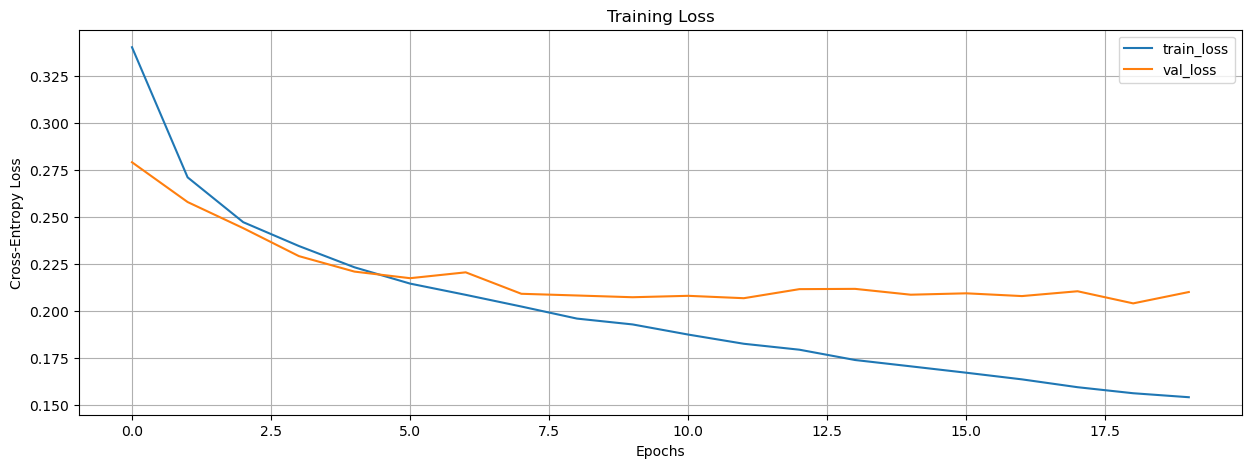

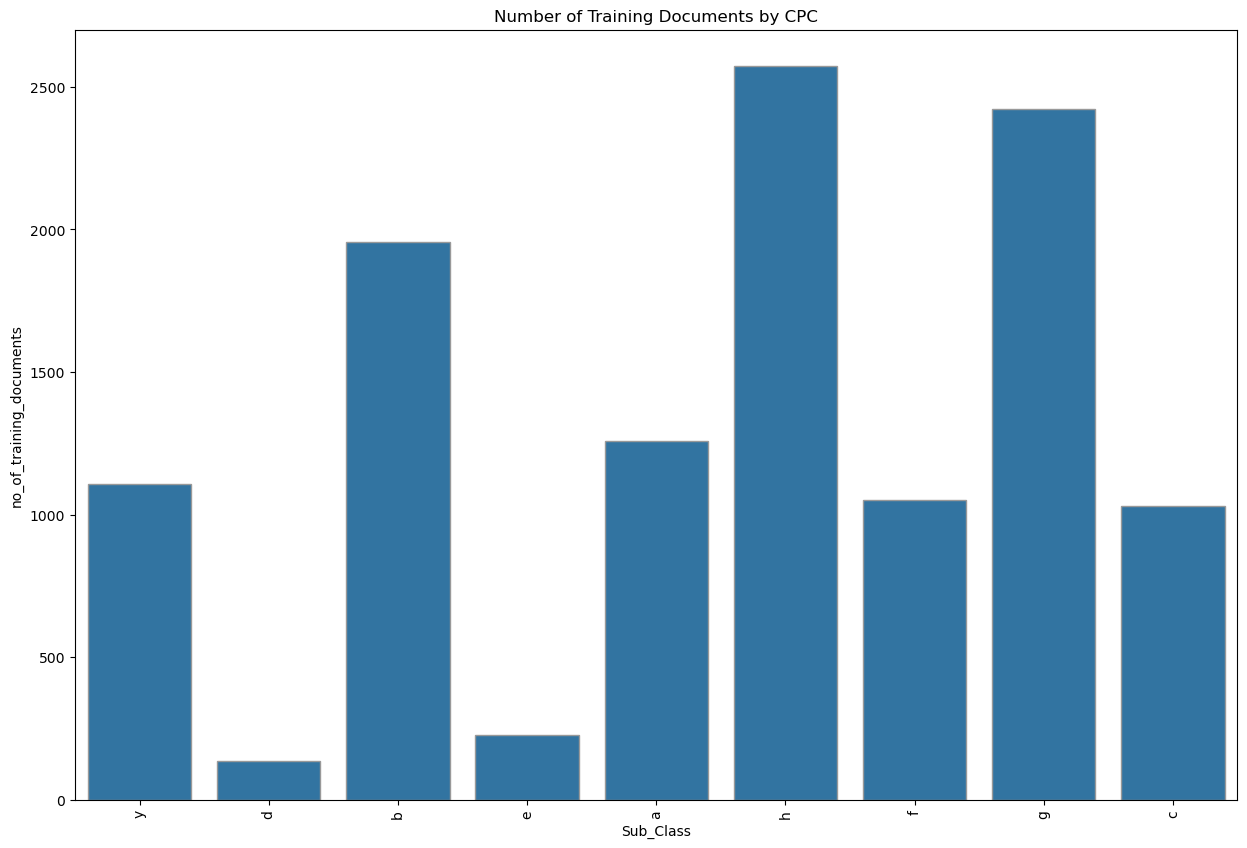

In [75]:
# Sorting by Error_percentage in descending order
Result_analysis = Result_analysis.sort_values(by='Error_percentage', ascending=False)

# Create the bar plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plotting all 9 CPCs
g = sns.barplot(y="no_of_training_documents", x="Sub_Class", edgecolor=".6",
                data=Result_analysis, ax=ax)

# Rotate x-axis labels for better visibility
g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Set plot title
g.set_title('Number of Training Documents by CPC')

# Display the plot
plt.show()

In [76]:
# Getting some examples on the classfication for the class 'd'

delta_incorrect_d=[]
for i,d in enumerate(delta):
    if 'd' in d:
        delta_incorrect_d.append(i)


df_with_results.iloc[delta_incorrect_d].head(10)

,predicted_cpcs,pred_probability,actual_cpcs,precision,recall
15,[a],[0.94750863],[d],0.0,0.000000
44,[b],[0.7639755],"[a, d, g]",0.0,0.000000
288,[b],[0.9498903],"[b, d]",1.0,0.500000
692,[f],[0.50556463],"[d, y]",0.0,0.000000
806,[a],[0.83284837],[d],0.0,0.000000
935,[e],[0.59024686],[d],0.0,0.000000
1035,[b],[0.8779241],"[b, d, e]",1.0,0.333333
1099,[f],[0.71407366],[d],0.0,0.000000
1148,[c],[0.9816444],"[c, d]",1.0,0.500000
1307,[f],[0.8195114],[d],0.0,0.000000
